In [1]:
# Packages
import pandas as pd
import numpy as np
import missingno as msno
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ax.service.ax_client import AxClient
from ax import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
df = pd.read_excel('/Volumes/UNTITLED/Documents/DATASET_SEWER/NORMALIZED/FILLED/FILLED_NORMAL_ALL_TMP1.xlsx')
df.head()

,MLSS,MLVSS,turbidity,train 1 TMP,mode,train 2 TMP,mode.1,train 3 TMP,mode.2,train 4 TMP,...,flows t 3,flows t 4,tds,total nitrogen,cod inf,cod enf,enf mgd,salinity inf,Unnamed: 30,Unnamed: 31
0,-0.280713,-0.162677,-0.889879,-1.599297,pro',0.650654,stb',-1.002140,pro',-0.454365,...,0.135955,-1.53908,NaN,NaN,NaN,NaN,0.052989,NaN,NaN,01-Jan-2020'
1,-1.072436,-0.884203,-0.858822,-0.955755,pro',-0.605422,pro',-0.739955,bkp',1.195036,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.364128,NaN,NaN,NaT'
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.879529,-0.708911,-0.905408,-1.017045,pro',-0.632434,pro',0.904660,bkp',0.598268,...,NaN,NaN,NaN,NaN,NaN,NaN,0.293710,NaN,NaN,NaT'


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MLSS            301 non-null    float64
 1   MLVSS           301 non-null    float64
 2   turbidity       301 non-null    float64
 3   train 1 TMP     302 non-null    float64
 4   mode            302 non-null    object 
 5   train 2 TMP     302 non-null    float64
 6   mode.1          302 non-null    object 
 7   train 3 TMP     302 non-null    float64
 8   mode.2          302 non-null    object 
 9   train 4 TMP     302 non-null    float64
 10  mode.3          302 non-null    object 
 11  ph inff         302 non-null    float64
 12  bod inff        55 non-null     float64
 13  bod pe          52 non-null     float64
 14  bod eff         55 non-null     float64
 15  tss inf         49 non-null     float64
 16  tss enf         49 non-null     float64
 17  temp inf        302 non-null    flo

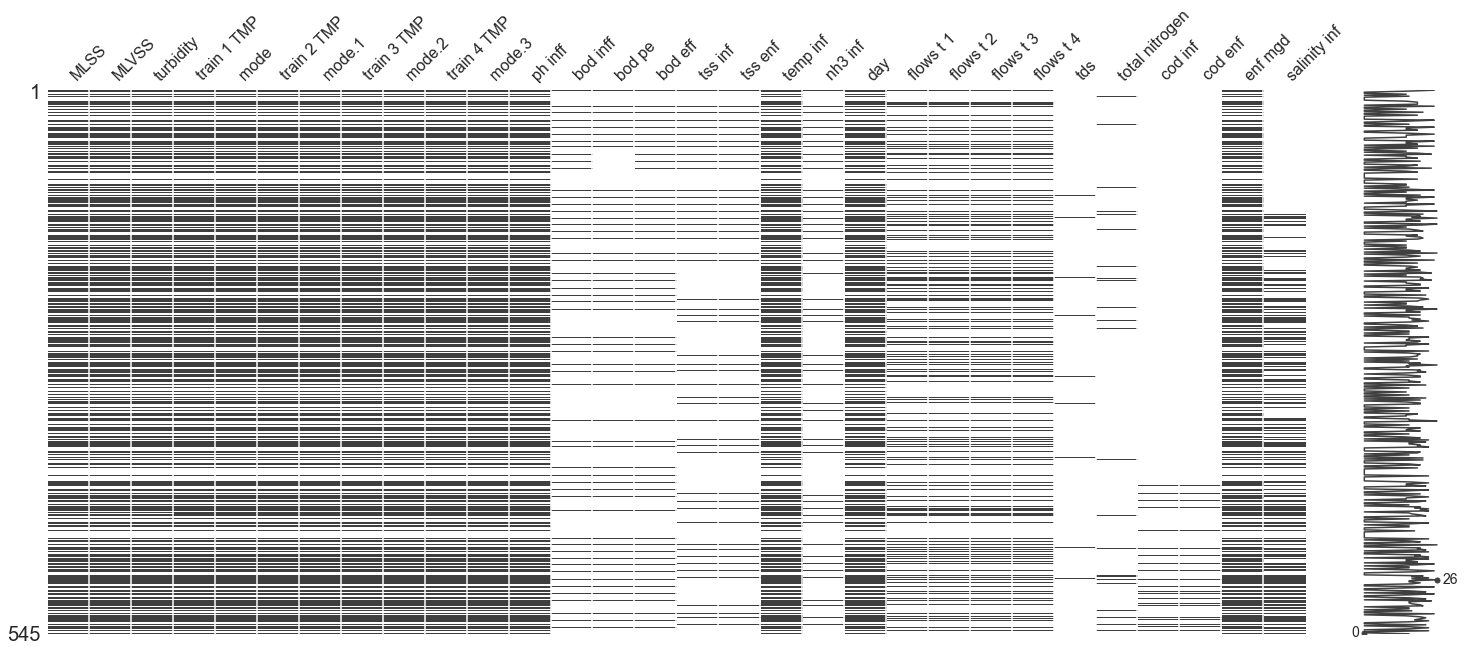

In [4]:
msno.matrix(df.iloc[:, :30])

data = df.drop(df.columns[[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 0, 29]], axis = 1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train 1 TMP  302 non-null    float64
 1   enf mgd      302 non-null    float64
dtypes: float64(2)
memory usage: 8.6 KB


In [6]:
data['enf mgd'].hist(bins=1000)

KeyError: 'MLSS'

In [ ]:
data.boxplot(column=['enf mgd'])

In [ ]:
data = data.dropna(axis = 0, how = "any")
y = data['train 1 TMP']

In [ ]:
data.info()

In [ ]:
data['enf mgd'].plot()

In [ ]:
pram_min = y.min()
pram_max = y.max()
pram_avg = y.mean()
pram_std = y.std()

In [ ]:
summary = {'Statistics of TMP': [pram_min, pram_max, pram_avg, pram_std]}
stat_mpg = pd.DataFrame(data=summary, index=['Min', 'Max','Avg','Std'])
stat_mpg

In [ ]:
stat_mpg.plot(kind='bar', color='goldenrod')

In [ ]:
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm')
data.info()

In [ ]:
data = data.drop('train 1 TMP', axis = 1)

In [ ]:
X = data
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
                   'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

In [ ]:
X_train_scaled = X_train
X_test_scaled = X_test

In [ ]:
# This returns a multi-layer-perceptron model in Keras.
def get_keras_model(num_hidden_layers,
                    num_neurons_per_layer,
                    dropout_rate,
                    activation):
    # create the MLP model.

    # define the layers.
    inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))  # input layer.
    x = layers.Dropout(dropout_rate)(inputs) # dropout on the weights.

    # Add the hidden layers.
    for i in range(num_hidden_layers):
        x = layers.Dense(num_neurons_per_layer,
                         activation=activation)(x)
        x = layers.Dropout(dropout_rate)(x)

    # output layer.
    outputs = layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# This function takes in the hyperparameters and returns a score (Cross validation).
def keras_mlp_cv_score(parameterization, weight=None):

    model = get_keras_model(parameterization.get('num_hidden_layers'),
                            parameterization.get('neurons_per_layer'),
                            parameterization.get('dropout_rate'),
                            parameterization.get('activation'))

    opt = parameterization.get('optimizer')
    opt = opt.lower()

    learning_rate = parameterization.get('learning_rate')

    if opt == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif opt == 'rms':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif opt == 'Ftrl':
        optimizer = tf.keras.optimizers.Ftrl(learning_rate=learning_rate)
    elif opt == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif opt == 'Adamax':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    elif opt == 'Adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif opt == 'Adadelta':
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    NUM_EPOCHS = 50

    # Specify the training configuration.
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['mse'])

    data = X_train_scaled
    labels = y_train.values

    # fit the model using a 20% validation set.
    res = model.fit(data, labels, epochs=NUM_EPOCHS, batch_size=parameterization.get('batch_size'),
                    validation_split=0.2)

    # look at the last 10 epochs. Get the mean and standard deviation of the validation score.
    last10_scores = np.array(res.history['val_loss'][-10:])
    mean = last10_scores.mean()
    sem = last10_scores.std()

    # If the model didn't converge then set a high loss.
    if np.isnan(mean):
        return 9999.0, 0.0

    return mean, sem

In [ ]:
# Define the search space.
parameters=[
    {
        "name": "learning_rate",
        "type": "range",
        "bounds": [0.0001, 0.5],
        "log_scale": True,
    },
    {
        "name": "dropout_rate",
        "type": "range",
        "bounds": [0.01, 0.5],
        "log_scale": True,
    },
    {
        "name": "num_hidden_layers",
        "type": "range",
        "bounds": [1, 10],
        "value_type": "int"
    },
    {
        "name": "neurons_per_layer",
        "type": "range",
        "bounds": [1, 300],
        "value_type": "int"
    },
    {
        "name": "batch_size",
        "type": "range",
        "bounds": [1, 500],
        'value_type' : 'int'
    },

    {
        "name": "activation",
        "type": "choice",
        "values": ['tanh', 'sigmoid', 'relu', 'softmax', 'selu', 'elu', 'LeakyReLU'],
    },
    {
        "name": "optimizer",
        "type": "choice",
        "values": ['adam', 'rms', 'sgd', 'Nadam', 'Ftrl', 'Adagrad', 'Adamax', 'Adadelta' ],
    },
]

In [ ]:
# import more packages
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render, init_notebook_plotting

init_notebook_plotting()

ax_client = AxClient()

# create the experiment.
ax_client.create_experiment(
    name="keras_experiment",
    parameters=parameters,
    objective_name='keras_cv',
    minimize=True)

def evaluate(parameters):
    return {"keras_cv": keras_mlp_cv_score(parameters)}

# Based on the search space, this will use Sobol (https://en.wikipedia.org/wiki/Sobol_sequence) instead of a Guassian Process (GPEI).
#
# From the source code:
#     """We should use only Sobol and not GPEI if:
#     1. there are less continuous parameters in the search space than the sum of
#     options for the choice parameters,
#     2. the number of total iterations in the optimization is known in advance and
#     there are less distinct points in the search space than the known intended
#     number of total iterations.
#     """

# Sobol sequences seem to be better than random for high-dimensional spaces:
# https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method

In [ ]:
for i in range(20):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

In [ ]:
# look at all the trials.
ax_client.get_trials_data_frame().sort_values('trial_index')

In [ ]:
# View best parameters
best_parameters, values = ax_client.get_best_parameters()

# the best set of parameters.
for k in best_parameters.items():
    print(k)

print()

# the best score achieved.
means, covariances = values
print(means)

In [ ]:
render(ax_client.get_optimization_trace()) # Objective_optimum is optional.

# Cannot do contour plot because it doesn't use a GP model.

In [ ]:
# save results to json file.
ax_client.save_to_json_file()

# restore the client from json file. Handy if you want to do more trials or if your computer crashed in the middle of the trials.
restored_ax_client = AxClient.load_from_json_file()